# Python Scripts to Explore AutoArborist Tree Dataset
The following code blocks include scripts for reading TFRecord files, generating summary statistics, displaying images, bounding boxes, and exporting data
Thomas Lake 
October 2023

# Parsing TFRecord Files From Auto Arborist Dataset

[Link to the Auto Arborist dataset](https://google.github.io/auto-arborist/)

## Contents

The dataset consists of CSVs containing approximately 4.5 million basic processed tree records from 23 cities and tfrecords that contain imagery for a subset of the trees.

- **README**: Information about the dataset.

- **tree_locations/**: Contains the parsed and cleaned up tree inventories of each city in the dataset, along with train/test splits per city. The CSVs have the following columns:
  - `IDX`: An identifier for the row unique to the city.
  - `SHAPE_LNG`: The longitude of the tree.
  - `SHAPE_LAT`: The latitude of the tree.
  - `GENUS`: The lowercase genus of the tree.
  - `TAXONOMY_ID`: A unique integer ID corresponding to the genus (indexed from 0).

- **tfrecords/**: Contains train/test TFRecord files with one aerial and blurred street-level image per available tree for all cities available in this release version. The trees are a subset of the trees in `tree_locations/`. The tfrecords have the following layout:
  - `tree/`
    - `id`: bytes. An ID for the tree that is unique across the release dataset.
    - `idx`: bytes. An ID linking to the `tree_locations/` CSV `IDX` for the tree.
    - `city`: bytes. The city where the tree is located.
    - `latitude`: float. The ground truth latitude of the tree.
    - `longitude`: float. The ground truth longitude of the tree.
    - `genus/`
      - `label`: int64. Holds the ground truth label number representing the tree’s genus.
      - `genus`: bytes. The ground truth genus of the tree.
  - `image/`
    - `aerial/`
      - `encoded`: bytes. An encoded aerial JPEG image of the tree approximately centered on its trunk.
    - `streetlevel/`
      - `encoded`: bytes. An encoded street-level JPEG image of the tree. Non-vegetation pixels are blurred.
      - `capturetime`: bytes. The month and year that the street-level image was captured.
      - `bbox/`: float_lists. Represent tree detection bounding boxes (based on Open Images) as regions scaled from [0, 1], with (0,0) representing the top-left corner of the image.
        - `xmin`
        - `xmax`
        - `ymin`
        - `ymax`
      - `center/`:
        - `x`: int64. Represents an approximate (but noisy) location for the horizontal center pixel of the tree in the image.
        - `y`: int64. This is always set to half of the image height and is provided for convenience.


# Import Libraries

In [1]:

# Install tensorflow: https://www.tensorflow.org/install/pip#windows-native_1
import tensorflow as tf # version 2.10

# File system and data libraries
import os
import pandas as pd
import numpy as np
import csv
import io
import shutil

# Plotting/Display Images
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle



# Import single TFRecord and inspect data structure
Inspect a TFRecord with TF2.0: https://stackoverflow.com/questions/42394585/how-to-inspect-a-tensorflow-tfrecord-file

In [ ]:
# Import single TFRecord file and inspect dictionary structure
# raw_dataset = tf.data.TFRecordDataset("C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/new_york/test-00000-of-00025.tfrecord")

# for raw_record in raw_dataset.take(1):
#    example = tf.train.Example()
#    example.ParseFromString(raw_record.numpy())
#    print(example)



# Parse TFRecord files 

In [2]:

# Define a function to parse both tree data and aerial/streetview imagery from a TFRecord example

def parse_tree_image_example(example):
    feature_description = {
        'tree/id': tf.io.FixedLenFeature([], tf.string),
        'tree/idx': tf.io.FixedLenFeature([], tf.string),
        'tree/city': tf.io.FixedLenFeature([], tf.string),
        'tree/latitude': tf.io.FixedLenFeature([], tf.float32),
        'tree/longitude': tf.io.FixedLenFeature([], tf.float32),
        'tree/genus/label': tf.io.FixedLenFeature([], tf.int64),
        'tree/genus/genus': tf.io.FixedLenFeature([], tf.string),
        'aerial/encoded': tf.io.FixedLenFeature([], tf.string),
        'streetlevel/encoded': tf.io.FixedLenFeature([], tf.string),
        'streetlevel/capturetime': tf.io.FixedLenFeature([], tf.string),
        'streetlevel/center/x': tf.io.FixedLenFeature([], tf.int64),
        'streetlevel/center/y': tf.io.FixedLenFeature([], tf.int64),
        'streetlevel/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'streetlevel/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'streetlevel/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'streetlevel/object/bbox/ymax': tf.io.VarLenFeature(tf.float32)
    }
    
    # Parse the TFRecord using the feature description
    parsed_tree_image_example = tf.io.parse_single_example(example, feature_description)
    
    return parsed_tree_image_example


In [3]:

# Define cities contained in the Auto Arborist Dataset
cities = ['bloomington', 'boulder', 'buffalo', 'calgary', 'cambridge', 'charlottesville', 'columbus', 
          'cupertino', 'denver', 'edmonton', 'kitchener', 'los_angeles', 'montreal', 'new_york', 'pittsburgh', 
          'santa_monica', 'san_francisco', 'san_jose', 'seattle', 'sioux_falls', 'surrey', 'vancouver', 'washington_dc']



# Read sample autoarborist records, display images and contents

Tree ID: 603391294617402369
Tree Location Index: 2d1d2b07-53cb-3e37-80a1-b0d6670a7db2
City: LosAngeles
Latitude: 34.2406
Longitude: -118.48732
Genus: prunus
Capture Time (Street): March 2019
Tree Center X (Street): 392
Tree Center Y (Street): 576
Bbox Min X (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([0.40186286 0.00494567], shape=(2,), dtype=float32), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64))
Bbox Max X (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([0.5324969  0.04831392], shape=(2,), dtype=float32), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64))
Bbox Min Y (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([0.29806468 0.2591094 ], shape=(2,), dtype=float32), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64))
Bbox Max Y (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=

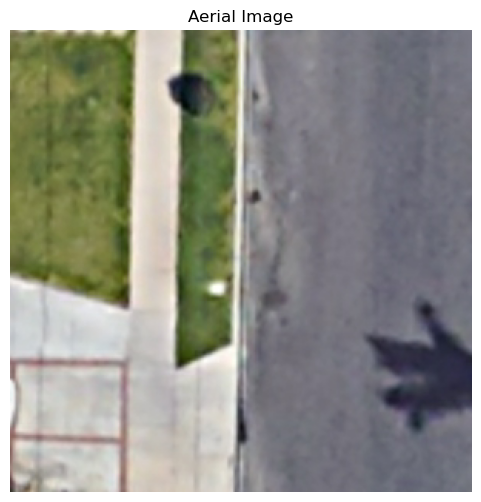

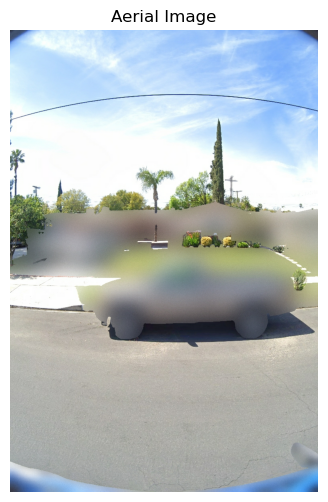


Tree ID: 5093651436113038993
Tree Location Index: 4180d87a-dd27-3b9d-804a-9407d6615dd7
City: LosAngeles
Latitude: 34.07692
Longitude: -118.30682
Genus: populus
Capture Time (Street): May 2019
Tree Center X (Street): 355
Tree Center Y (Street): 576
Bbox Min X (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([0.09752676 0.7233706  0.5682397 ], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64))
Bbox Max X (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([0.93623424 0.8659378  0.78156316], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64))
Bbox Min Y (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([0.         0.25842103 0.28793654], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64))
Bbox Max Y (0-1; Street): SparseTensor(i

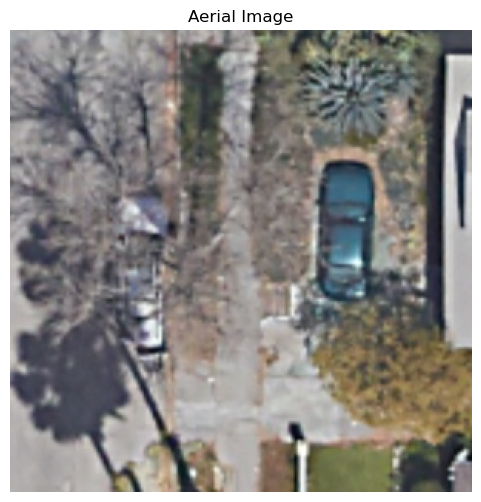

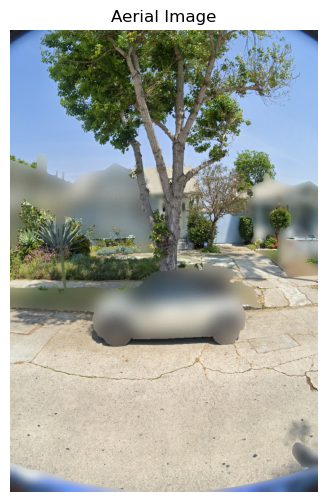


Tree ID: 17343495371114852669
Tree Location Index: 5cb1c460-a7f1-35c1-bfb5-60a4ac199eb8
City: LosAngeles
Latitude: 34.250134
Longitude: -118.538994
Genus: albizia
Capture Time (Street): December 2020
Tree Center X (Street): 541
Tree Center Y (Street): 576
Bbox Min X (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]], shape=(7, 1), dtype=int64), values=tf.Tensor(
[0.28261918 0.8179731  0.45397753 0.41877997 0.15384361 0.3198247
 0.7126284 ], shape=(7,), dtype=float32), dense_shape=tf.Tensor([7], shape=(1,), dtype=int64))
Bbox Max X (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]], shape=(7, 1), dtype=int64), values=tf.Tensor(
[0.39514816 0.8571499  0.49708676 0.45256335 0.24987748 0.35536098
 0.7659757 ], shape=(7,), dtype=float32), dense_shape=tf.Tensor([7], shape=(1,), dtype=int64))
Bbox Min Y (0-1; Street): SparseTensor(indices=tf.Tensor(
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]], shape=(7, 1), dtype=int64), values=tf.Tenso

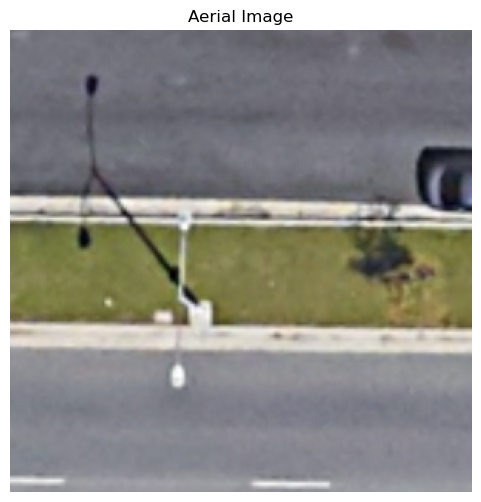

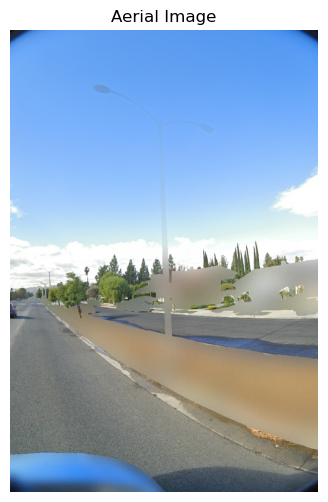

In [9]:
# Inspect the tree data and imagery records

cities = ['los_angeles']

for city in cities:
    # Set Directory
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'

    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    parsed_tree_imagery_dataset = dataset.map(parse_tree_image_example)

    for record in parsed_tree_imagery_dataset.take(3):

        # Tree information
        print("Tree ID:", record['tree/id'].numpy().decode('utf-8'))
        print("Tree Location Index:", record['tree/idx'].numpy().decode('utf-8'))
        print("City:", record['tree/city'].numpy().decode('utf-8'))
        print("Latitude:", record['tree/latitude'].numpy())
        print("Longitude:", record['tree/longitude'].numpy())  
        print("Genus:", record['tree/genus/genus'].numpy().decode('utf-8'))
        print("Capture Time (Street):", record['streetlevel/capturetime'].numpy().decode('utf-8'))
        print("Tree Center X (Street):", record['streetlevel/center/x'].numpy())
        print("Tree Center Y (Street):", record['streetlevel/center/y'].numpy())
        print("Bbox Min X (0-1; Street):", record['streetlevel/object/bbox/xmin'])
        print("Bbox Max X (0-1; Street):", record['streetlevel/object/bbox/xmax'])
        print("Bbox Min Y (0-1; Street):", record['streetlevel/object/bbox/ymin'])
        print("Bbox Max Y (0-1; Street):", record['streetlevel/object/bbox/ymax'])

        # Image information
        # Decode the binary image data to JPEG format
        aerial_image = tf.image.decode_jpeg(record['aerial/encoded'], fancy_upscaling = False)
        # print(aerial_image.shape) # (300 x 300 x 3)
        streetlevel_image = tf.image.decode_jpeg(record['streetlevel/encoded'], fancy_upscaling = False)
        # print(streetlevel_image.shape) # (1152, 768, 3)

        # Display the aerial image
        plt.figure(figsize=(6, 6))
        plt.imshow(aerial_image)
        plt.title('Aerial Image')
        plt.axis('off')
        plt.show()

        # Display the aerial image
        plt.figure(figsize=(6, 6))
        plt.imshow(streetlevel_image)
        plt.title('Aerial Image')
        plt.axis('off')
        plt.show()

        print("=" * 40 + "\n")


# Write TFRecord data as a CSV file

In [ ]:

# Utility: convert TFRecords to CSV Data 

csv_data = []

for city in cities:
    # Set Directory
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'

    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    parsed_tree_imagery_dataset = dataset.map(parse_tree_image_example)

    for record in parsed_tree_imagery_dataset:
         # Tree information
        csv_data.append([
        record['tree/id'].numpy().decode('utf-8'),
        record['tree/idx'].numpy().decode('utf-8'),
        record['tree/city'].numpy().decode('utf-8'),
        record['tree/latitude'].numpy(),
        record['tree/longitude'].numpy(),
        record['tree/genus/genus'].numpy().decode('utf-8'),
        record['tree/genus/label'].numpy(),
        record['streetlevel/capturetime'].numpy().decode('utf-8'),
        record['streetlevel/center/x'].numpy(),
        record['streetlevel/center/y'].numpy()])
        
    # Define the path to save the CSV file
csv_file_path = r'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords_csv/tfrecords_locs_all.csv'

# Check if the directory exists, create it if not
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Write data to CSV file
#with open(csv_file_path, 'w', newline='') as csvfile:
    #csv_writer = csv.writer(csvfile)

    # Write the header row
    #csv_writer.writerow(['Tree ID', 'Tree Location IDX', 'City', 'Latitude', 'Longitude', 'Genus', 'Genus Label', 'Capture Time Street Img', 'Tree Center X Street Img', 'Tree Center Y Street Img'])

    # Write the data rows
    #csv_writer.writerows(csv_data)

#print(f"CSV file saved at: {csv_file_path}")
       
        



# Merge the TFRecord CSV file with the /tree_locations csv file provided with the Autoarborist dataset

In [ ]:
# Utliity: Merge AutoArborist IDX values between tree_locations CSV file and TFRecords files

# Read in both CSV files to compare
csv_tree_locations = r'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tree_locations/tree_locs_all.csv'
tfrecord_tree_locations = r'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords_csv/tfrecords_locs_all.csv'

csv_df = pd.read_csv(csv_tree_locations)
tfrecord_df = pd.read_csv(tfrecord_tree_locations)

# Merge the DataFrames based on the common columns ("IDX" and "Tree Location IDX")
merged_df = pd.merge(csv_df, tfrecord_df, left_on="IDX", right_on="Tree Location IDX", how='inner')

print(merged_df)

#merged_df.to_csv(r'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tree_locations/tree_locations_tfrecord_locations_idx_merged.csv')


# Open Autoarborist TFRecord Images and Class Labels, Plot Bounding Boxes, and Write to File

In [ ]:

# Utility: Open Autoarborist TFRecord Images and Class Labels, and Write to File
# Select only records for target species, and save JPGs by IDX values

for city in cities: 
    # Set Directory
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'

    # List of TFRecord training files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord training dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    # Parse training and testing TFRecords
    parsed_streetview_tree_image_label = dataset.map(parse_tree_image_example)
    
    for record in parsed_streetview_tree_image_label:
        #if record['tree/genus/genus'].numpy().decode('utf-8') == 'rhus':
            
        # Get streetlevel image
        streetlevel_image = tf.image.decode_jpeg(record['streetlevel/encoded'], fancy_upscaling=False)

        # Get image label genus (string) and genus label (int)
        genus_name = record['tree/genus/genus'].numpy().decode('utf-8')
        idx_value = record['tree/id'].numpy().decode('utf-8')

        # Get bounding box information
        xmin_values = record['streetlevel/object/bbox/xmin'].values.numpy()
        xmax_values = record['streetlevel/object/bbox/xmax'].values.numpy()
        ymin_values = record['streetlevel/object/bbox/ymin'].values.numpy()
        ymax_values = record['streetlevel/object/bbox/ymax'].values.numpy()

        # Check if folder exists, if not, create it
        save_folder = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/jpegs_{genus_name}/'
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        if len(xmin_values) == 1: # Save records with a single bounding box labeled to genus
            #print(len(xmin_values))

            # Display the streetview
            plt.figure(figsize=(6, 6))
            plt.imshow(streetlevel_image)
            plt.title(f'Street View Image: {genus_name}')
            plt.axis('off')

            # Display multiple bounding boxes on top of the image
            for i in range(len(xmin_values)):
                # Scale the bounding box coordinates from [0-1] to pixel values
                xmin = int(xmin_values[i] * streetlevel_image.shape[1])
                xmax = int(xmax_values[i] * streetlevel_image.shape[1])
                ymin = int(ymin_values[i] * streetlevel_image.shape[0])
                ymax = int(ymax_values[i] * streetlevel_image.shape[0])

                # Add bounding box rectangle to the image
                current_axis = plt.gca()
                current_axis.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color='red', fill=False, linewidth=2))

            # Save the image
            plt.savefig(f'{save_folder}/one-bbox-{idx_value}.jpg')
            plt.close()

            # Save streetlevel image
            tf.keras.utils.save_img(f'{save_folder}/{idx_value}.jpg', streetlevel_image)


        if len(xmin_values) > 1: # Save records with multiple bounding boxes labelled to genus
            print(len(xmin_values))

            # Display the streetview
            plt.figure(figsize=(6, 6))
            plt.imshow(streetlevel_image)
            plt.title(f'Street View Image: {genus_name}')
            plt.axis('off')

            # Display multiple bounding boxes on top of the image
            for i in range(len(xmin_values)):
                # Scale the bounding box coordinates from [0-1] to pixel values
                xmin = int(xmin_values[i] * streetlevel_image.shape[1])
                xmax = int(xmax_values[i] * streetlevel_image.shape[1])
                ymin = int(ymin_values[i] * streetlevel_image.shape[0])
                ymax = int(ymax_values[i] * streetlevel_image.shape[0])

                # Add bounding box rectangle to the image
                current_axis = plt.gca()
                current_axis.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color='red', fill=False, linewidth=2))

            # Save the image
            plt.savefig(f'{save_folder}/multi-bbox-{idx_value}.jpg')
            plt.close()

            # Save streetlevel image
            tf.keras.utils.save_img(f'{save_folder}/{idx_value}.jpg', streetlevel_image)



# Count and plot histograms for total number of genera in all cities from autoarborist images

In [ ]:
# Utility: Summarize the total number of genera in all cities and regions from streetview imagery

cities = ['bloomington', 'boulder', 'buffalo', 'calgary', 'cambridge', 'charlottesville', 'columbus', 
          'cupertino', 'denver', 'edmonton', 'kitchener', 'los_angeles', 'montreal', 'new_york', 'pittsburgh', 
          'santa_monica', 'san_francisco', 'san_jose', 'seattle', 'sioux_falls', 'surrey', 'vancouver', 'washington_dc']

genus_name_counts = {}

for city in cities:
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'
    # Rest of your code for processing TFRecord files goes here

    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    parsed_tree_imagery_dataset = dataset.map(parse_tree_image_example)

    for record in parsed_tree_imagery_dataset:
        # Get the genus name from the record
        genus_name = record['tree/genus/genus'].numpy().decode('utf-8')  # Decode bytes to string

        # Update the name count in the dictionary
        if genus_name in genus_name_counts:
            genus_name_counts[genus_name] += 1
        else:
            genus_name_counts[genus_name] = 1
            
    #print(genus_name_counts)

# Print the genus name counts
for name, count in genus_name_counts.items():
    print(f"Genus Name '{name}': {count} occurrences")


In [ ]:
# Utility: Create histograms of the number of genera / city from streetview imagery

# Sort the genus_name_counts dictionary by values in descending order
sorted_genus_counts = {k: v for k, v in sorted(genus_name_counts.items(), key=lambda item: item[1], reverse=True)}

#print(sorted_genus_counts)

# Extract genus names and their counts for plotting
genus_names = list(sorted_genus_counts.keys())
counts = list(sorted_genus_counts.values())

# Create a bar plot
plt.figure(figsize=(30, 10))
plt.bar(genus_names, counts, color='skyblue')
plt.xlabel('Genus Name')
plt.ylabel('Occurrences')
plt.title('Genus Name Occurrences')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


# Display top N categories
top_n_categories = 50  # Choose the number of top categories to display
sorted_genus_counts_top_n = dict(list(sorted_genus_counts.items())[:top_n_categories])

# Extract genus names and their counts for plotting
genus_names = list(sorted_genus_counts_top_n.keys())
counts = list(sorted_genus_counts_top_n.values())

# Create a bar plot
plt.figure(figsize=(30, 15))
plt.bar(genus_names, counts, color='skyblue')
plt.xlabel('Genus Name')
plt.ylabel('Occurrences')
plt.title('Top Genus Name Occurrences')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()




# Summarize number of trees, number of unique genera by city and region from streetview imagery

In [ ]:
# Utility: Summarize number of trees, number of genera by city and region from streetview imagery

cities = ['bloomington', 'boulder', 'buffalo', 'calgary', 'cambridge', 'charlottesville', 'columbus', 
          'cupertino', 'denver', 'edmonton', 'kitchener', 'los_angeles', 'montreal', 'new_york', 'pittsburgh', 
          'santa_monica', 'san_francisco', 'san_jose', 'seattle', 'sioux_falls', 'surrey', 'vancouver', 'washington_dc']

regions = ['east', 'central', 'east', 'central', 'east', 'east', 'east', 'west', 'central', 'central',
          'east', 'west', 'east', 'east', 'east', 'west', 'west', 'west', 'west', 'central', 'west', 'west', 'east']

# Dictionary to store counts of trees and unique genera by city and region
city_region_tree_counts = {}
city_region_genus_counts = {}

# Initialize the dictionaries for each city and region
for city, region in zip(cities, regions):
    city_region_tree_counts.setdefault(region, {}).setdefault(city, 0)
    city_region_genus_counts.setdefault(region, {}).setdefault(city, set())

genus_name_counts = {}

for city, region in zip(cities, regions):
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'
    # Rest of your code for processing TFRecord files goes here

    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    parsed_tree_imagery_dataset = dataset.map(parse_tree_image_example)

    for record in parsed_tree_imagery_dataset:
        # Update tree counts by city and region
        city_region_tree_counts[region][city] += 1

        # Get and decode tree genus names
        genus_name = record['tree/genus/genus'].numpy().decode('utf-8')
        city_region_genus_counts[region][city].add(genus_name)

# Print tree and unique genus counts by city and region
for region, city_data in city_region_tree_counts.items():
    print(f"Region: {region}")
    for city, tree_count in city_data.items():
        unique_genus_count = len(city_region_genus_counts[region][city])
        print(f"City: {city}, Number of Trees: {tree_count}, Number of Unique Genera: {unique_genus_count}")
    print("=" * 40)



# Plot Images, Bounding Boxes for Labels (Genera)

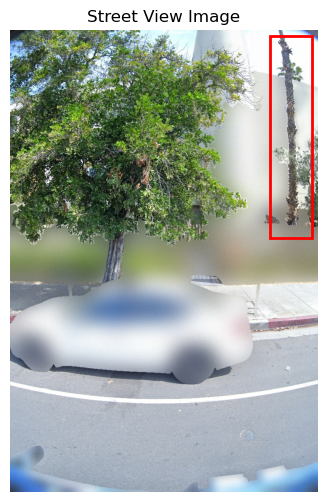

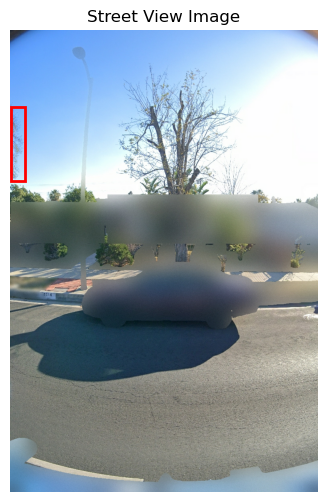

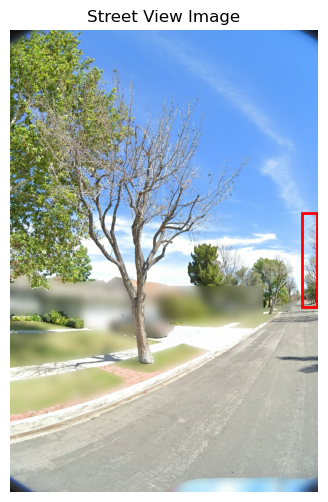

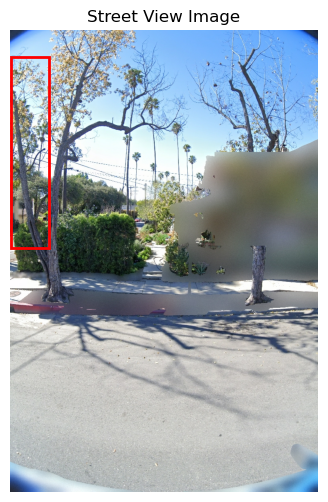

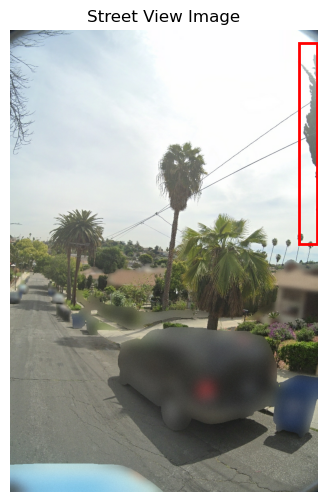

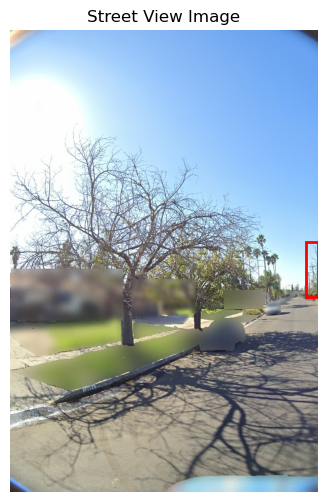

In [23]:

# Get streetview tree records and bounding boxes of ailanthus for select cities

cities = ['bloomington', 'boulder', 'buffalo', 'calgary', 'cambridge', 'charlottesville', 'columbus', 
          'cupertino', 'denver', 'edmonton', 'kitchener', 'los_angeles', 'montreal', 'new_york', 'pittsburgh', 
          'santa_monica', 'san_francisco', 'san_jose', 'seattle', 'sioux_falls', 'surrey', 'vancouver', 'washington_dc']

cities = ['los_angeles']

# Define a function to calculate aspect ratio of bounding boxes
def calculate_aspect_ratio(xmin, xmax, ymin, ymax):
    width = xmax - xmin
    height = ymax - ymin
    aspect_ratio = height / width
    return aspect_ratio


for city in cities:
    # Set Directory
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'
    
    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    # Parse TFRecords as streetview tree images
    parsed_streetview_tree_image_label = dataset.map(parse_tree_image_example)
    
    for record in parsed_streetview_tree_image_label.take(100):
        #print("Tree Location Index:", record['tree/idx'].numpy().decode('utf-8'))

        # Decode the street-view images
        streetlevel_image = tf.image.decode_jpeg(record['streetlevel/encoded'], fancy_upscaling=False)

        # Get bounding box information
        xmin_values = record['streetlevel/object/bbox/xmin'].values.numpy()
        xmax_values = record['streetlevel/object/bbox/xmax'].values.numpy()
        ymin_values = record['streetlevel/object/bbox/ymin'].values.numpy()
        ymax_values = record['streetlevel/object/bbox/ymax'].values.numpy()

        # Display bounding boxes based on aspect ratio
        for i in range(len(xmin_values)):
            aspect_ratio = calculate_aspect_ratio(xmin_values[i], xmax_values[i], ymin_values[i], ymax_values[i])
            
            # Filter out tall and skinny bounding boxes (large height, small width)
            if aspect_ratio > 3: #or < 0.25
                xmin = int(xmin_values[i] * streetlevel_image.shape[1])
                xmax = int(xmax_values[i] * streetlevel_image.shape[1])
                ymin = int(ymin_values[i] * streetlevel_image.shape[0])
                ymax = int(ymax_values[i] * streetlevel_image.shape[0])
                
                # Display the streetview
                plt.figure(figsize=(6, 6))
                plt.imshow(streetlevel_image)
                plt.title('Street View Image')
                plt.axis('off')

                current_axis = plt.gca()
                current_axis.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color='red', fill=False, linewidth=2))
            
#             # Filter out wide and narrow bounding boxes (small height, large width)
#             elif aspect_ratio < 0.25:
#                 xmin = int(xmin_values[i] * streetlevel_image.shape[1])
#                 xmax = int(xmax_values[i] * streetlevel_image.shape[1])
#                 ymin = int(ymin_values[i] * streetlevel_image.shape[0])
#                 ymax = int(ymax_values[i] * streetlevel_image.shape[0])
                
#                 # Display the streetview
#                 plt.figure(figsize=(6, 6))
#                 plt.imshow(streetlevel_image)
#                 plt.title('Street View Image')
#                 plt.axis('off')

#                 current_axis = plt.gca()
#                 current_axis.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color='blue', fill=False, linewidth=2))

        plt.show()
        #print("=" * 40 + "\n")







# Histogram of the number of bounding boxes per image for each city. Average ~ 4 bounding boxes / image

In [ ]:
# Create a list to store the total number of bounding boxes for each city
total_bbox_counts = []


cities = ['bloomington', 'boulder', 'buffalo', 'calgary', 'cambridge', 'charlottesville', 'columbus', 
          'cupertino', 'denver', 'edmonton', 'kitchener', 'los_angeles', 'montreal', 'new_york', 'pittsburgh', 
          'santa_monica', 'san_francisco', 'san_jose', 'seattle', 'sioux_falls', 'surrey', 'vancouver', 'washington_dc']

for city in cities:
    # Set Directory
    tfrecord_dir = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'

    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/*.tfrecord')

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    # Parse TFRecords as streetview tree images
    parsed_streetview_tree_image_label = dataset.map(parse_tree_image_example)

    # Iterate through the dataset and calculate total bounding boxes for each city
    for record in parsed_streetview_tree_image_label:
        # Get bounding box information
        genus = record['tree/genus/genus'].numpy().decode('utf-8')
        xmin_values = record['streetlevel/object/bbox/xmin'].values.numpy()

        # Count the number of bounding boxes
        num_bboxes = len(xmin_values)

        # Append the total number of bounding boxes to the list
        total_bbox_counts.append(num_bboxes)

# Plot histogram of total bounding boxes for each city
plt.figure(figsize=(10, 6))
plt.hist(total_bbox_counts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Bounding Boxes')
plt.ylabel('Frequency')
plt.title('Distribution of Total Bounding Boxes in Each City')
plt.grid(True)
plt.show()
    




# Export Image JPEG and Text File (YOLO Format) Containing Image and Bounding Box of Tree Instances

In [ ]:
# Utility: Export Image JPEG and Text File (YOLO Format) Containing Image and Bounding Box of Tree Instances
# Text file follows YOLOv5 Format: https://roboflow.com/formats/yolov5-pytorch-txt

# Set paths for output directories
base_output_dir = r'/mnt/c/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/yolov5/datasets/autoarborist/'
train_output_dir = os.path.join(base_output_dir, 'train')
test_output_dir = os.path.join(base_output_dir, 'test')

print(train_output_dir)

cities = ['bloomington', 'boulder', 'buffalo', 'calgary', 'cambridge', 'charlottesville', 'columbus', 
          'cupertino', 'denver', 'edmonton', 'kitchener', 'los_angeles', 'montreal', 'new_york', 'pittsburgh', 
          'santa_monica', 'san_francisco', 'san_jose', 'seattle', 'sioux_falls', 'surrey', 'vancouver', 'washington_dc']

for city in cities:
    print(city)
    # Set Directory
    tfrecord_dir = f'/mnt/c/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/tfrecords/{city}'
    
    # List of TFRecord files
    tfrecord_files = tf.data.Dataset.list_files(tfrecord_dir + '/train*.tfrecord') #Change if we want training or testing data

    # Create a TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    # Parse TFRecords as streetview tree images
    parsed_streetview_tree_image_label = dataset.map(parse_tree_image_example)
    
    for record in parsed_streetview_tree_image_label:
        idx = record['tree/idx'].numpy().decode('utf-8')
        #print("Tree Location Index:", idx)
        
        # Determine if the record is from training or testing data
        #is_training = 'train' in tfrecord_file.numpy().decode('utf-8')
        #output_dir = train_output_dir if is_training else test_output_dir
        
        # Decode the street-view images
        streetlevel_image = tf.image.decode_jpeg(record['streetlevel/encoded'], fancy_upscaling=False)
        
        # Get bounding box information
        xmin_values = record['streetlevel/object/bbox/xmin'].values.numpy() * streetlevel_image.shape[1]
        xmax_values = record['streetlevel/object/bbox/xmax'].values.numpy() * streetlevel_image.shape[1]
        ymin_values = record['streetlevel/object/bbox/ymin'].values.numpy() * streetlevel_image.shape[0]
        ymax_values = record['streetlevel/object/bbox/ymax'].values.numpy() * streetlevel_image.shape[0]

        # Inspect images/bounding boxes to verify correct
        # print(xmin_values)
        # print(xmax_values)
        # print(ymin_values)
        # print(ymax_values)

        # # Plot the street-level image
        # plt.figure(figsize=(8, 8))
        # plt.imshow(streetlevel_image)
        # plt.title('Street View Image')
        # plt.axis('off')
                
        # # Plot bounding boxes on top of the image
        # for i in range(len(xmin_values)):
        #     # Scale the bounding box coordinates from [0-1] to pixel values
        #     xmin = int(xmin_values[i])
        #     xmax = int(xmax_values[i])
        #     ymin = int(ymin_values[i])
        #     ymax = int(ymax_values[i])
        
        #     # Add bounding box rectangle to the image
        #     current_axis = plt.gca()
        #     current_axis.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color='red', fill=False, linewidth=2))
        
        # # Show the image with bounding boxes
        # plt.show()

        # Export the image
        image_filename = f'{idx}.jpeg'
        image_path = os.path.join(train_output_dir, 'images', image_filename)
        if not os.path.exists(image_path):
            #os.makedirs(os.path.dirname(image_path), exist_ok=True)
            tf.keras.utils.save_img(image_path, streetlevel_image)

            # Export bounding box information to text file
            txt_filename = f'{idx}.txt'
            txt_path = os.path.join(train_output_dir, 'labels', txt_filename)
            #os.makedirs(os.path.dirname(txt_path), exist_ok=True)
            with open(txt_path, 'w') as txt_file:
                for i in range(len(xmin_values)):
                    # Normalize bounding box coordinates
                    class_id = 0  # Class indices start with 0
                    center_x = ((xmin_values[i] + xmax_values[i]) / 2) / streetlevel_image.shape[1]
                    center_y = ((ymin_values[i] + ymax_values[i]) / 2) / streetlevel_image.shape[0]
                    width = (xmax_values[i] - xmin_values[i]) / streetlevel_image.shape[1]
                    height = (ymax_values[i] - ymin_values[i]) / streetlevel_image.shape[0]
    
                    # Write bounding box information to the text file
                    txt_file.write(f'{class_id} {center_x} {center_y} {width} {height}\n')





In [ ]:
#EOF